<a href="https://colab.research.google.com/github/AndyMDH/augmented_image_classification_sigmoid_relu/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCK506 Mid-Module Assignment: FashionMNIST Image Classification with Neural Networks
By: Andy Ho

**Table of Contents**
1. Introduction
2. Exploratory Data Analysis
3. Data Preprocessing
4. Building Model 1
  - Neural Network Architecture
  - Compiling
  - Training
  - Evaluation
5. Building Model 2
  - Neural Network Architecture
  - Compiling
  - Training
  - With Dropout Rates
  - Evaluation
6. Analysis and Retrospective



## Introduction
In this Jupyter Notebook, we explore the domain of Deep Learning (DL) through the implementation of a neural network tailored for the classification of images within the Fashion MNIST dataset. The goal of this summative assignment is to explore the efficacy of different configurations of neural network architectures and optimization techniques.

The Fashion MNIST dataset, comprising of 60,000 training images and 10,000 testing images, presents a rich resource for studying Machine Learning algorithms in the domain of apparel recognition. Each image in the dataset corresponds to one of ten distinct categories, representing various articles of clothing and accessories. The class in the MNIST dataset are as follows:

0.	T-shirt/top
1.	Trouser
2.	Pullover
3.	Dress
4.	Coat
5.	Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot

Our approach involves utilising a two hidden layer fully connected neural network, employing Stochastic Gradient Descent (SGD) as the optimiser, the Sigmoid Activation function, and the cross-entropy error function.

To begin, we'll set the parametres such as epoch=10 and batch size=1000 and proceed with training the neural network. Through this process, we aim to observe the performance metrics, including training loss, training accuracy, test loss, and test accuracy.

In the subsequent stage, we delve deeper into the intricacies of neural network optimization by introducing variations to our initial setup. Specifically, we replace the Sigmoid Activation function with Rectified Linear Units (ReLU) and incorporate Dropout regularization.

***Importing Dependencies***

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Loading Fashion MNIST Dataset**

To obtain the direct download link for the Fashion MNIST dataset, we can visit the Kaggle [dataset](https://www.kaggle.com/zalando-research/fashionmnist) and click on the **Download** button on the right-hand side of the page. Alternatively for the sake of this assignment, 'keras.datasets.fashion_mnist' provides a convenient manner for us to directly load the Fashion MNIST dataset into our Python environment.



In [4]:
# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


---
## Exploratory Data Analysis

In [3]:
# Check dataset dimensions
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [4]:
# Distribution of labels in training and test sets
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

print("Training set label distribution:")
for label, count in train_label_counts.items():
    print(f"Label {label}: {count} samples")

print("\nTest set label distribution:")
for label, count in test_label_counts.items():
    print(f"Label {label}: {count} samples")

Training set label distribution:
Label 9: 6000 samples
Label 0: 6000 samples
Label 3: 6000 samples
Label 2: 6000 samples
Label 7: 6000 samples
Label 5: 6000 samples
Label 1: 6000 samples
Label 6: 6000 samples
Label 4: 6000 samples
Label 8: 6000 samples

Test set label distribution:
Label 9: 1000 samples
Label 2: 1000 samples
Label 1: 1000 samples
Label 6: 1000 samples
Label 4: 1000 samples
Label 5: 1000 samples
Label 7: 1000 samples
Label 3: 1000 samples
Label 8: 1000 samples
Label 0: 1000 samples


In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

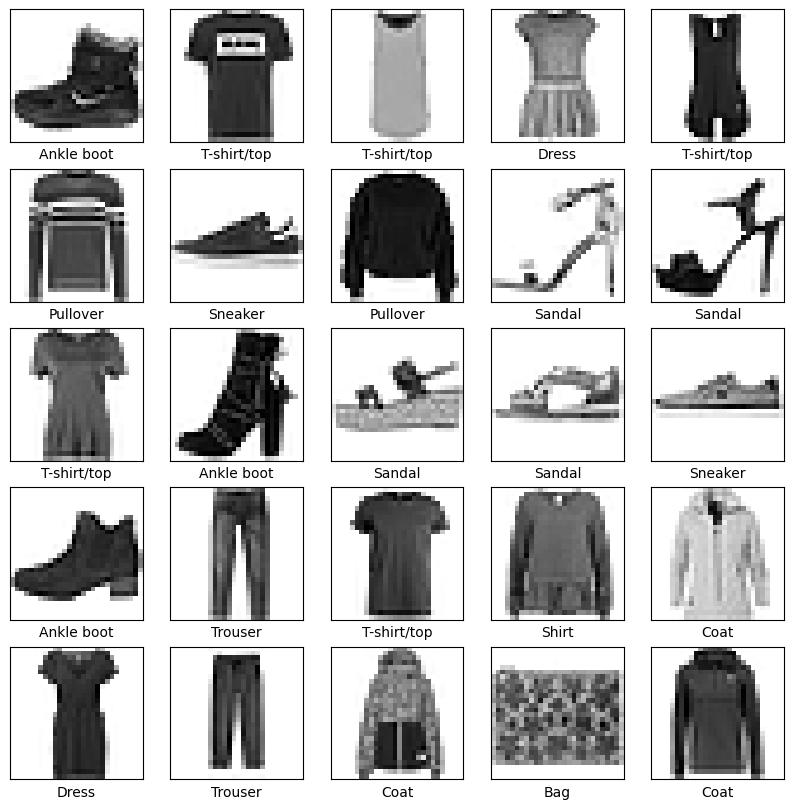

In [6]:
# Visualize sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

---
## Data Preprocessing
Before constructing our architecture, we need to preprocess our data. This stage involves adjusting the scale of our grayscale pixel values, originally ranging from 0 to 255, to a normalized scale between 0 and 1. We achieve this by dividing each pixel value in both the training and testing sets by 255.0. By scaling the pixel values to a smaller range, it simplifies the computational task for the model, aiding in its efficiency during training.

Additionally, we employ data augmentation techniques to enhance the robustness and generalization capability of our model for image classification tasks. The **create_augmented_data_generator** function applies various transformations, such as rotation, shifts, and flipping, to augment the training dataset, thereby increasing its diversity and improving the model's ability to generalise to unseen data. The augmentation process is facilitated using the ImageDataGenerator class, while also ensuring that pixel values are rescaled to a normalized range.

The reshaped array transforms the original dataset into a 4-dimensional array, where each element represents an image. The dimensions are structured as follows:

- The first dimension denotes the number of images, automatically determined based on the size of the original array.
- The subsequent two dimensions represent the height and width of each image, set to 28x28 pixels in this case.
- Lastly, the fourth dimension signifies the number of channels per image, with a value of 1 indicating grayscale images. For color images, this value would typically be 3, representing the red, green, and blue channels.

In contrast, the **create_test_data_generator** function prepares the test dataset without augmentation, ensuring unbiased evaluation of the model's performance on unseen data. These augmentation strategies play a vital role in training deep learning models effectively, contributing to improved performance and robustness in real-world applications.

In [7]:
def create_augmented_data_generator(train_images, train_labels):
    # Call the ImageDataGenerator class for training data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255.  # Rescale training data
    )

    # Pass in the appropriate arguments to the flow method for training data
    train_data_generator = train_datagen.flow(
        x=train_images.reshape(-1, 28, 28, 1),  # Reshape images to fit NN input shape
        y=train_labels,
        batch_size=32
    )

    return train_data_generator

def create_test_data_generator(test_images, test_labels):
    # Call the ImageDataGenerator class for test data (without augmentation)
    test_datagen = ImageDataGenerator(rescale=1./255.)

    # Pass in the appropriate arguments to the flow method for test data
    test_data_generator = test_datagen.flow(
        x=test_images.reshape(-1, 28, 28, 1),  # Reshape images to fit NN input shape
        y=test_labels,
        batch_size=32
    )

    return test_data_generator

In [8]:
# Call the function to create augmented data generator for training set
train_data_generator = create_augmented_data_generator(train_images, train_labels)

# Call the function to create data generator for test set
test_data_generator = create_test_data_generator(test_images, test_labels)

In [9]:
# Select one image from the training set
image = train_images[15].reshape(1, 28, 28, 1)

# Define the data augmentation generator
train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
)

# Generate augmented images from the single image
augmented_images = [train_datagen.flow(image, batch_size=1)[0][0] for _ in range(5)]

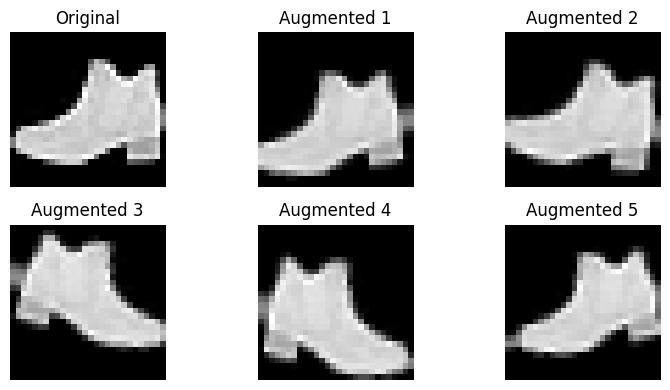

In [10]:
# Plot the original and augmented images
plt.figure(figsize=(8, 4))
plt.subplot(2, 3, 1)
plt.title('Original')
plt.imshow(image.reshape(28, 28), cmap='gray')
plt.axis('off')
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(2, 3, i + 2)
    plt.title(f'Augmented {i+1}')
    plt.imshow(augmented_image.reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Building Model 1
This stage involves constructing the model using a Keras Sequential model, comprising four distinct layers. This architecture embodies a feed-forward neural network architecture, propagating values from left to right. A comprehensive elucidation of each layer and its architectural attributes will be provided subsequently.

In [19]:
# Defining our Neural Network architecture
model_1 = Sequential([
    Flatten(input_shape=(28, 28)),     # Input layer
    Dense(128, activation='sigmoid'),  # Input layer with 128 neurons
    Dense(64, activation='sigmoid'),   # First hidden layer with 64 neurons
    Dense(32, activation='sigmoid'),   # Second hidden layer with 32 neurons
    Dense(10, activation='softmax')    # Output layer with 10 neurons (for 10 classes) using softmax activation
])

# Compile the model
model_1.compile(optimizer=SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Layer 1:** This is our input layer and it will conist of 784 neurons. We use the flatten layer with an input shape of (28,28) to denote that our input should come in in that shape. The flatten means that our layer will reshape the shape (28,28) array into a vector of 784 neurons so that each pixel will be associated with one neuron.

**Layer 2:** This is our first hidden layer. The *dense* denotes that this layer will be fully connected and each neuron from the previous layer connects to each neuron of this layer. It has 64 neurons and uses the sigmoid activation function.

**Layer 3:** This is our second hidden layer. The *dense* denotes that this layer will be fully connected and each neuron from the previous hidden layer connects to each neuron of this layer. It has 32 neurons and uses the sigmoid activation function.

**Layer 4:** Serving as our output layer, this dense layer encompasses 10 neurons, each responsible for discerning the likelihood of an image belonging to one of the 10 distinct classes. Employing the softmax activation function, this layer computes a probability distribution across the classes. Consequently, the value of each neuron within this layer ranges between 0 and 1, with a value closer to 1 indicating a higher likelihood of the corresponding image belonging to the associated class.

In [20]:
# Train the model
history = model_1.fit(train_data_generator,
                    epochs=10,
                    batch_size=1000,
                    validation_data=test_data_generator)

Epoch 1/10
1875/1875 [==============================] - 32s 17ms/step - loss: 1.7110 - accuracy: 0.3433 - val_loss: 1.2280 - val_accuracy: 0.4956
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 1.1919 - accuracy: 0.5342 - val_loss: 1.0066 - val_accuracy: 0.6110
Epoch 3/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.9630 - accuracy: 0.6401 - val_loss: 0.7928 - val_accuracy: 0.6963
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.8396 - accuracy: 0.6812 - val_loss: 0.7981 - val_accuracy: 0.6983
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.7882 - accuracy: 0.6992 - val_loss: 0.7052 - val_accuracy: 0.7298
Epoch 6/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.7530 - accuracy: 0.7120 - val_loss: 0.7010 - val_accuracy: 0.7327
Epoch 7/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.7288 - accuracy: 0.7208 - val_loss: 0.6633 -

In [21]:
# Get train loss and accuracy
train_loss, train_accuracy = model_1.evaluate(train_images, train_labels, verbose=0)
print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

# Get test loss and accuracy
test_loss, test_accuracy = model_1.evaluate(test_images, test_labels, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Train Loss: 0.9079843759536743, Train Accuracy: 0.6902999877929688
Test Loss: 0.9312640428543091, Test Accuracy: 0.6823999881744385


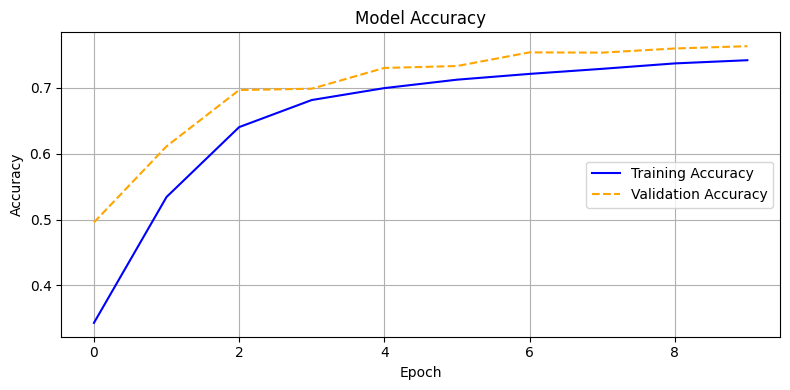

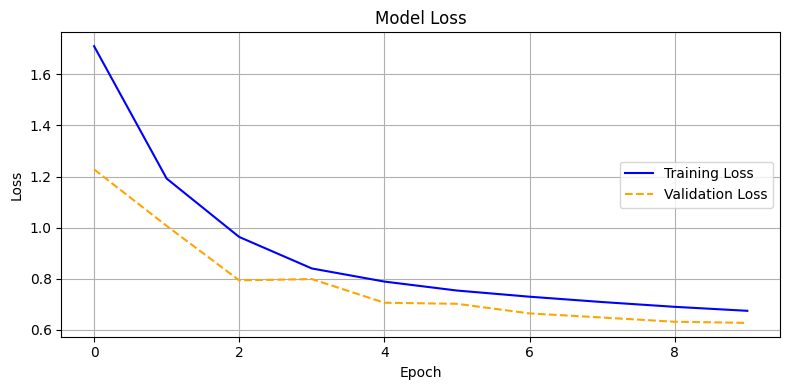

In [22]:
def plot_metrics(history, metric='accuracy'):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric], label='Training ' + metric.capitalize(), color='blue', linestyle='-')
    plt.plot(history.history['val_' + metric], label='Validation ' + metric.capitalize(), color='orange', linestyle='--')
    plt.title('Model ' + metric.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics(history, metric='accuracy')
plot_metrics(history, metric='loss')

Yes, data augmentation can increase the training time significantly, especially if you're using techniques like rotation, shifting, and flipping. These operations increase the diversity of your training data, which can lead to better generalization of your model. However, they also require additional computational resources and time during training.

Here are a few strategies you can consider to mitigate the longer training times:

Reduce the Augmentation Intensity: You can reduce the range of augmentation parameters such as rotation angle, width and height shift ranges, and flipping probability. This will decrease the computational load while still providing some regularization benefits.

Increase Batch Size: Using a larger batch size can help in utilizing GPU resources more efficiently, potentially reducing training time per epoch.

Overfitting: As the training progresses, the model may start to memorize the training data rather than learning the underlying patterns. This can cause a decrease in performance on unseen data.

Model Complexity: The model might be too complex for the given dataset, leading to overfitting. In such cases, simplifying the model architecture or adding regularization techniques like dropout could help.

Hyperparameter Tuning: The model's hyperparameters, such as learning rate or batch size, might not be optimized for this specific dataset. Fine-tuning these hyperparameters could potentially improve performance.

Data Quality: The quality of the training data could affect the model's performance. Noisy or inconsistent data might lead to suboptimal performance.

To address this issue, you could try the following:

Implement regularization techniques such as dropout or L2 regularization to prevent overfitting.
Experiment with different model architectures, including adding or removing layers, to find a better fit for the data.
Adjust hyperparameters such as learning rate, batch size, or optimizer choice to optimize model performance.

---
## Building Model 2 Architecture
Now it's time to build the model! We are going to use a keras *sequential* model with three different layers. This model represents a feed-forward neural network (one that passes values from left to right). We'll break down each layer and its architecture below.

It consists of:

In [29]:
# Define your neural network architecture
model_2 = Sequential([
    Flatten(input_shape=(28, 28)),  # input layer (1)
    Dense(128, activation='relu'),  # Input layer with 128 neurons
    Dense(64, activation='relu'),   # First hidden layer with 64 neurons
    Dense(32, activation='relu'),   # Second hidden layer with 32 neurons
    Dense(10, activation='softmax') # Output layer with 10 neurons (for 10 classes) using softmax activation
])

# Compile the model
model_2.compile(optimizer=SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Train the model
history = model_2.fit(train_data_generator,
                    epochs=10,
                    batch_size=1000,
                    validation_data=test_data_generator)

Epoch 1/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.8990 - accuracy: 0.6569 - val_loss: 0.6630 - val_accuracy: 0.7449
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.7018 - accuracy: 0.7313 - val_loss: 0.6028 - val_accuracy: 0.7684
Epoch 3/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.6548 - accuracy: 0.7488 - val_loss: 0.5824 - val_accuracy: 0.7830
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.6276 - accuracy: 0.7593 - val_loss: 0.6137 - val_accuracy: 0.7630
Epoch 5/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.5996 - accuracy: 0.7697 - val_loss: 0.5491 - val_accuracy: 0.7923
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.5857 - accuracy: 0.7766 - val_loss: 0.5678 - val_accuracy: 0.7888
Epoch 7/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.5700 - accuracy: 0.7833 - val_loss: 0.5278 -

With dropout rates

In [35]:
# Neural network architecture with dropout regularization
model_2_dropout = Sequential([
    Flatten(input_shape=(28, 28)),  # input layer (1)
    Dense(128, activation='relu'),  # Input layer with 128 neurons
    Dropout(0.2),                    # Dropout layer with 20% dropout rate
    Dense(64, activation='relu'),    # First hidden layer with 64 neurons
    Dropout(0.2),
    Dense(32, activation='relu'),    # Second hidden layer with 32 neurons
    Dropout(0.2),
    Dense(10, activation='softmax')  # Output layer with 10 neurons (for 10 classes) using softmax activation
])

# Compile the model with dropout
model_2_dropout.compile(optimizer=SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Train the model
history = model_2_dropout.fit(train_data_generator,
                              epochs=10,
                              batch_size=1000,
                              validation_data=test_data_generator)

Epoch 1/10
1875/1875 [==============================] - 102s 54ms/step - loss: 1.0905 - accuracy: 0.5887 - val_loss: 0.7214 - val_accuracy: 0.7056
Epoch 2/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.8531 - accuracy: 0.6789 - val_loss: 0.6621 - val_accuracy: 0.7443
Epoch 3/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7993 - accuracy: 0.6948 - val_loss: 0.6230 - val_accuracy: 0.7525
Epoch 4/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.7708 - accuracy: 0.7104 - val_loss: 0.6410 - val_accuracy: 0.7481
Epoch 5/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.7505 - accuracy: 0.7143 - val_loss: 0.6019 - val_accuracy: 0.7733
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.7348 - accuracy: 0.7203 - val_loss: 0.5955 - val_accuracy: 0.7718
Epoch 7/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.7221 - accuracy: 0.7260 - val_loss: 0.5729 